In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

[fedora:28672] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.fedora.1000/jf.0/1766195200/shared_mem_cuda_pool.fedora could be created.
[fedora:28672] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
mesh = dl.IntervalMesh(500, -1.5, 1.5)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time",
    inference_type="drift_only",
    log_squared_diffusion=("std::log(std::pow(x[0],2) + 2)",),
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [3]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",), spin_problem.function_space_parameters
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)
data_stride = 10
data_locations = solution_coordinates[::data_stride]
data_values = true_solution[::data_stride]
rng = np.random.default_rng(seed=0)
noise_std = 0.01
noise = rng.normal(loc=0, scale=noise_std, size=data_values.size)
data_values = data_values + noise

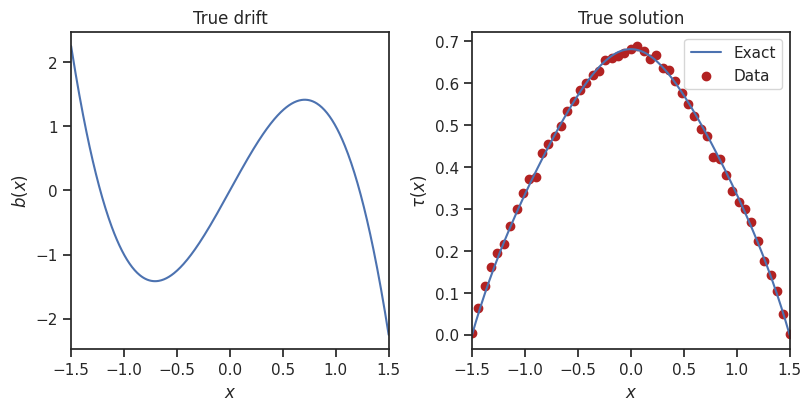

In [4]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_parameter)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[1].plot(solution_coordinates, true_solution, label="Exact")
axs[1].scatter(data_locations, data_values, color="firebrick", label="Data")
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True solution")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\tau(x)$")
axs[1].legend()

In [5]:
right_hand_side = 0.1 * np.ones_like(true_solution)
true_adjoint = spin_problem.solve_adjoint(true_solution, true_parameter, right_hand_side)
true_gradient = spin_problem.evaluate_gradient(true_solution, true_parameter, right_hand_side)

Text(0, 0.5, '$g(x)$')

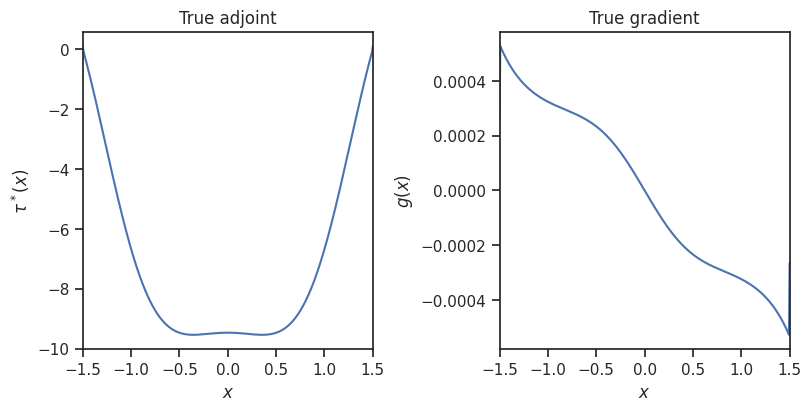

In [6]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(solution_coordinates, true_adjoint)
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True adjoint")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$\tau^*(x)$")
axs[1].plot(parameter_coordinates, true_gradient)
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True gradient")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$g(x)$")

In [7]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]",),
    variance=("1",),
    correlation_length=("0.001",),
    robin_bc=True,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=500
)

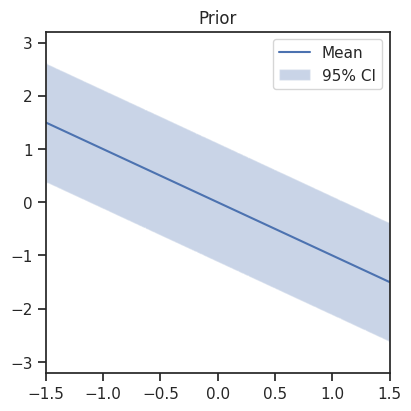

In [8]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, spin_prior.mean_array, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array - 1.96 * np.sqrt(prior_variance),
    spin_prior.mean_array + 1.96 * np.sqrt(prior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Prior")
ax.set_xlim(-1.5, 1.5)
ax.legend()

In [9]:
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]",),
    spin_problem.function_space_parameters,
)
prior_grad_vector = dl.Vector(true_parameter.vector())
spin_prior.hippylib_prior.grad(true_parameter.vector(), prior_grad_vector)
prior_grad_array = converter.convert_to_numpy(
    prior_grad_vector, spin_problem.function_space_parameters
)

(-1.5, 1.5)

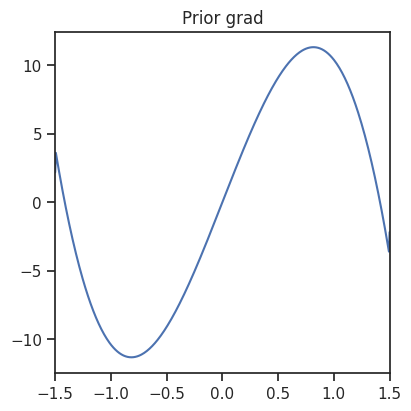

In [21]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, prior_grad_array)
ax.set_title("Prior grad")
ax.set_xlim(-1.5, 1.5)

In [11]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=data_locations,
    observation_values=data_values,
    noise_variance=np.ones(data_locations.size) * noise_std**2,
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

In [12]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem, spin_prior.hippylib_prior, spin_misfit
)

In [13]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-6, absolute_tolerance=1e-4, verbose=True
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    9.532984e+04    9.425985e+04    1.069986e+03   -1.257587e+05   8.000177e+04   1.000000e+00   5.000000e-01
  2   1    6.760784e+04    6.534844e+04    2.259405e+03   -7.394508e+03   1.037032e+04   1.000000e+00   3.600363e-01
  3   3    6.610572e+04    6.374663e+04    2.359087e+03   -4.017476e+01   4.796063e+02   1.000000e+00   7.742704e-02
  4   3    6.610587e+04    6.374679e+04    2.359075e+03   -5.508862e-01   3.229271e+01   9.765625e-04   2.009104e-02
Termination reason: Maximum number of backtracking reached


In [14]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=20,
    num_oversampling=5,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

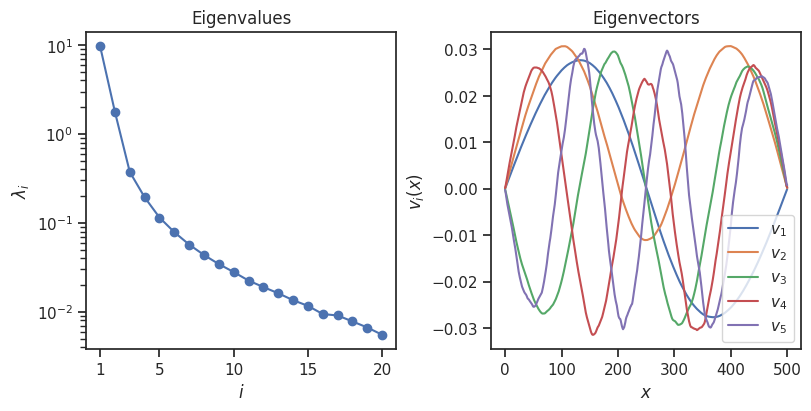

In [15]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].semilogy(index_vector, eigenvalues, marker="o")
axs[0].set_title("Eigenvalues")
axs[0].set_xticks((1, 5, 10, 15, 20))
axs[0].set_xlabel(r"$i$")
axs[0].set_ylabel(r"$\lambda_i$")
for i in range(5):
    axs[1].plot(eigenvectors[i], label=f"$v_{i + 1}$")
axs[1].set_title("Eigenvectors")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$v_i(x)$")
axs[1].legend()

In [18]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=500
)

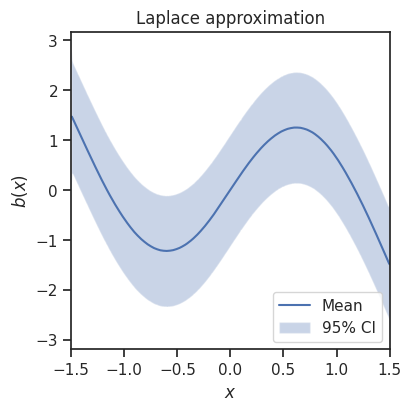

In [19]:
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.plot(parameter_coordinates, solver_solution.optimal_parameter, label="Mean")
ax.fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter - 1.96 * np.sqrt(posterior_variance),
    solver_solution.optimal_parameter + 1.96 * np.sqrt(posterior_variance),
    alpha=0.3,
    label="95% CI",
)
ax.set_title("Laplace approximation")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$b(x)$")
ax.set_xlim((-1.5, 1.5))
ax.legend()